In [832]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

<h5>Function to generate synthetic data</h5>

In [1015]:
def generate_synthetic_data(n_samples=1000, n_features=10, n_important=3, noise_level=0.1, random_state=None):
    """
    Generates synthetic data with known important features.
    
    Parameters:
    - n_samples (int): Number of samples.
    - n_features (int): Total number of features.
    - n_important (int): Number of important features.
    - noise_level (float): Standard deviation of the Gaussian noise.
    - random_state (int, optional): Seed for reproducibility.
    
    Returns:
    - X (pd.DataFrame): Feature matrix.
    - y (np.array): Target vector.
    - important_features (list): List of important feature indices.
    """
    
    if random_state is not None:
        np.random.seed(random_state)

    X = np.random.randn(n_samples, n_features)
    
    important_features = [i for i in range(n_important)]
    coefficients = np.random.randn(n_important)
    
    linear_combination = np.dot(X[:, important_features], coefficients)
    
    #linear_combination += noise_level * np.random.randn(n_samples)
    
    probabilities = 1 / (1 + np.exp(-linear_combination))
    
    y = np.random.binomial(1, probabilities)
    
    return X, y, important_features

<h5>Function to discretize vactor</h5>

In [971]:
def discretize_vector(vector):
    vec_bins = np.linspace(vector.min(), vector.max(), 10)
    return np.digitize(vector, bins=vec_bins)

<h5>Mutual information score</h5>

In [972]:
def mutual_info(X, Y, y=1):
    if y == 1:
        return mutual_info_score(discretize_vector(X), Y)
    else:
        return mutual_info_score(discretize_vector(X), discretize_vector(Y))

<h5>Conditional Mutual Information</h5>

In [973]:
def conditional_mutual_information(X_i, X_j, Y):
    y_values = np.unique(Y)
    n_y_values = len(y_values)
    n = len(Y)
    
    X_i_dis = discretize_vector(X_i)  
    X_j_dis = discretize_vector(X_j)
    
    cmi = 0

    for i in range(n_y_values):

        y_value_tmp = y_values[i]
        y_condition = (Y == y_value_tmp)

        X_i_z = X_i_dis[y_condition]
        X_j_z = X_j_dis[y_condition]

        mi_XiXj_y = mutual_info_score(X_i_z, X_j_z)
        p_y = np.sum(y_condition)/n

        cmi += p_y*mi_XiXj_y

    return cmi

<h2>Function to calculate Mutual Information Feature Selection</h2>

In [974]:
def MIFS(X, Y, k, Beta=1):
    # X: List of features
    # Y: Target variable
    # k: Number of features to select - Stopping Rule

    selected_features = []
    mifs_values = []
    n = X.shape[1]

    
    MI = [mutual_info(X[:,i], Y) for i in range(n)]
    
    first_feature = np.argmax(MI)
    selected_features.append(first_feature)
    mifs_values.append(np.max(MI))
    
    for j in range(1, k):
        max_score = -np.inf
        next_feature = -1
        
        for i in range(n):
            if i not in selected_features:
                redundancy = sum([mutual_info(X[:,i], X[:,f], y=0) for f in selected_features])

                score = MI[i] - Beta * redundancy
                
                if score > max_score:
                    max_score = score
                    next_feature = i
        
        selected_features.append(next_feature)
        mifs_values.append(max_score)
    
    return selected_features, mifs_values

<h2>Function to calculate Joint Mutual Information</h2>

In [975]:
def JMI(X, Y, k):
    # X: List of features
    # Y: Target variable
    # k: Number of features to select - Stopping Rule
    
    selected_features = []
    jmi_values = []
    n = X.shape[1]

    MI = [mutual_info(X[:,i], Y) for i in range(n)]

    first_feature = np.argmax(MI)
    selected_features.append(first_feature)
    jmi_values.append(np.max(MI))

    for j in range(1, k):
        max_score = -np.inf
        next_feature = -1

        for i in range(n):
            if i not in selected_features:
                redundancy = sum([mutual_info(X[:,i], X[:,f], y=0) - conditional_mutual_information(X[:,i], X[:,f], Y) for f in selected_features])

                score = MI[i] - 1/len(selected_features) * redundancy

                if score > max_score:
                    max_score = score
                    next_feature = i
        
        selected_features.append(next_feature)
        jmi_values.append(max_score)

    return selected_features, jmi_values

<h2>Function to calculate MINI-MAX </h2>

In [976]:
def CMIM(X, Y, k):
    # X: List of features
    # Y: Target variable
    # k: Number of features to select - Stopping Rule
    
    selected_features = []
    cmim_values = []
    n = X.shape[1]

    MI = [mutual_info(X[:,i], Y) for i in range(n)]

    first_feature = np.argmax(MI)
    selected_features.append(first_feature)
    cmim_values.append(np.max(MI))

    for j in range(1, k):
        max_score = -np.inf
        next_feature = -1

        for i in range(n):
            if i not in selected_features:

                redundancy = np.max([mutual_info(X[:,i], X[:,f], y=0) - conditional_mutual_information(X[:,i], X[:,f], Y) for f in selected_features])
        
                score = MI[i] - redundancy

                if score > max_score:
                    max_score = score
                    next_feature = i
        
        selected_features.append(next_feature)
        cmim_values.append(max_score)

    return selected_features, cmim_values

In [977]:
def LassoImportance(X, Y):
    lasso = LassoCV(cv=5)
    lasso.fit(X, Y)
    
    lasso_importances = np.abs(lasso.coef_)
    lasso_importance_df = pd.DataFrame({'Feature': range(X.shape[1]), 'Importance': lasso_importances})
    lasso_importance_df = lasso_importance_df.sort_values(by='Importance', ascending=False)
    return lasso_importance_df

In [978]:
def RandomForrestImportance(X,Y):
    model = RandomForestClassifier()
    model.fit(X, Y)
    
    importances = model.feature_importances_
    
    importance_df = pd.DataFrame({'Feature': range(X.shape[1]), 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

<h2>1st Arificial Dataset</h2>

In [1018]:
X, Y, important_features = generate_synthetic_data(n_samples=10000, n_features=15, n_important=5, noise_level=0)

In [1019]:
important_features

[0, 1, 2, 3, 4]

In [1020]:
LassoImportance(X, Y).head(6)

Feature  Importance
2         2    0.229741
0         0    0.163170
1         1    0.143209
3         3    0.130483
4         4    0.110942
14       14    0.005508

In [1021]:
RandomForrestImportance(X, Y).head(6)

Feature  Importance
2         2    0.238242
0         0    0.141746
1         1    0.116816
3         3    0.100177
4         4    0.082909
10       10    0.032743

In [1022]:
JMI(X, Y, 7)

([2, 0, 1, 3, 4, 9, 8],
 [0.11187677856826773,
  0.07128273487181276,
  0.05182299696478716,
  0.04144256099669672,
  0.032065855157151726,
  0.0034013977058741335,
  0.003172851430549388])

In [1023]:
MIFS(X, Y, 7, Beta=0.1)

([2, 0, 1, 3, 4, 10, 8],
 [0.11187677856826773,
  0.05418946750006994,
  0.04057595923301675,
  0.03298722724980414,
  0.02527637985399709,
  -0.0006466332811574311,
  -0.0012848031192667217])

In [1024]:
CMIM(X, Y, 7)

([2, 0, 1, 3, 4, 9, 8],
 [0.11187677856826773,
  0.07128273487181276,
  0.04819849760663725,
  0.03816828149700202,
  0.030455910194421766,
  0.0026929872639049786,
  0.002569054409286326])

In [1032]:
n = 50 
n_important = 5
sum_JMI = 0
sum_MIFS = 0 
sum_CMIM = 0
sum_Lasso = 0
sum_Random = 0
for i in range(n):
    X, Y, important_features = generate_synthetic_data(n_samples=500, n_features=15, n_important=n_important)
    features_JMI, _ = JMI(X, Y, 5)
    features_MIFS, _ = MIFS(X, Y, 5)
    features_CMIM, _ = CMIM(X, Y, 5)
    featureLasso = LassoImportance(X, Y)
    featureRandomForrest = RandomForrestImportance(X, Y)
    setImportantFeatures = set(important_features)
    setJMI = set(features_JMI)
    setMIFS = set(features_MIFS)
    setCMIM = set(features_CMIM)
    setLasso = set(featureLasso['Feature'].head(5))
    setRandom = set(featureRandomForrest['Feature'].head(5))
    
    sum_JMI += len(setJMI&setImportantFeatures)
    sum_MIFS += len(setMIFS&setImportantFeatures)
    sum_CMIM += len(setCMIM&setImportantFeatures)
    sum_Lasso += len(setJMI&setLasso)
    sum_Random += len(setMIFS&setRandom)


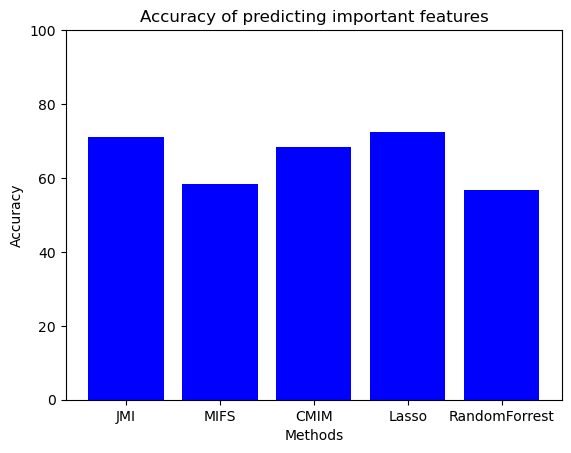

<Figure size 640x480 with 0 Axes>

In [1033]:
categories = ['JMI', 'MIFS', 'CMIM', 'Lasso', 'RandomForrest']
values = [100*sum_JMI/(n*n_important), 100*sum_MIFS/(n*n_important), 100*sum_CMIM/(n*n_important), 100*sum_Lasso/(n*n_important), 100*sum_Random/(n*n_important)]

plt.bar(categories, values, color='blue')

plt.ylim((0, 100))
plt.title('Accuracy of predicting important features')
plt.xlabel('Methods')
plt.ylabel('Accuracy')

plt.show()
plt.savefig('500iter.png')

In [1034]:
n = 50 
n_important = 5
sum_JMI = 0
sum_MIFS = 0 
sum_CMIM = 0
sum_Lasso = 0
sum_Random = 0
for i in range(n):
    X, Y, important_features = generate_synthetic_data(n_samples=5000, n_features=15, n_important=n_important)
    features_JMI, _ = JMI(X, Y, 5)
    features_MIFS, _ = MIFS(X, Y, 5)
    features_CMIM, _ = CMIM(X, Y, 5)
    featureLasso = LassoImportance(X, Y)
    featureRandomForrest = RandomForrestImportance(X, Y)
    setImportantFeatures = set(important_features)
    setJMI = set(features_JMI)
    setMIFS = set(features_MIFS)
    setCMIM = set(features_CMIM)
    setLasso = set(featureLasso['Feature'].head(5))
    setRandom = set(featureRandomForrest['Feature'].head(5))
    
    sum_JMI += len(setJMI&setImportantFeatures)
    sum_MIFS += len(setMIFS&setImportantFeatures)
    sum_CMIM += len(setCMIM&setImportantFeatures)
    sum_Lasso += len(setJMI&setLasso)
    sum_Random += len(setMIFS&setRandom)


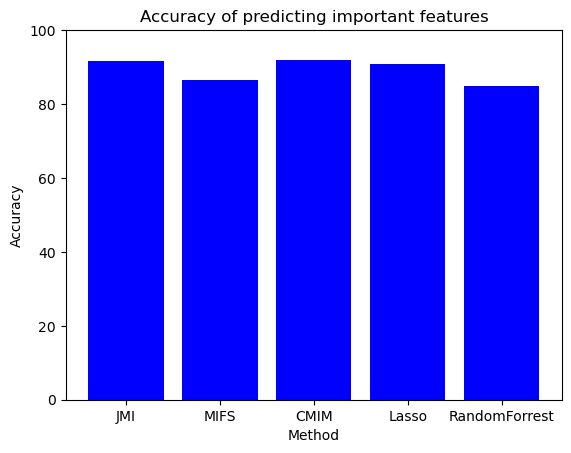

<Figure size 640x480 with 0 Axes>

In [1035]:
categories = ['JMI', 'MIFS', 'CMIM', 'Lasso', 'RandomForrest']
values = [100*sum_JMI/(n*n_important), 100*sum_MIFS/(n*n_important), 100*sum_CMIM/(n*n_important), 100*sum_Lasso/(n*n_important), 100*sum_Random/(n*n_important)]

plt.bar(categories, values, color='blue')
plt.ylim((0, 100))

plt.title('Accuracy of predicting important features')
plt.xlabel('Method')
plt.ylabel('Accuracy')

plt.show()
plt.savefig('5000iter.png')

In [1000]:
n_samples = 50

X1 = np.random.uniform(-3, 3, n_samples)
X2 = np.random.uniform(-3, 3, n_samples)
X3 = np.random.uniform(-3, 3, n_samples)
X4 = np.random.uniform(-3, 3, n_samples)
X5 = np.random.uniform(-3, 3, n_samples)
X6 = np.random.uniform(-3, 3, n_samples)
X7 = np.random.uniform(-3, 3, n_samples)
X8 = np.random.uniform(-3, 3, n_samples)

Y = np.sin(X1 * X2 * X3)

num_bins = 2
Y_bins = pd.cut(Y, num_bins, labels=False)

data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'X5': X5, 'X6': X6, 'X7': X7, 'X8': X8, 'Y': Y_bins})

In [1001]:
Y = data.Y
X = np.array(data.drop(['Y'], axis=1))

In [1002]:
#Important features 0, 1, 2

In [1003]:
LassoImportance(X, Y)

Feature  Importance
0        0         0.0
1        1         0.0
2        2         0.0
3        3         0.0
4        4         0.0
5        5         0.0
6        6         0.0
7        7         0.0

In [1004]:
RandomForrestImportance(X, Y)

Feature  Importance
4        4    0.140774
6        6    0.139058
1        1    0.132627
3        3    0.130059
2        2    0.125776
0        0    0.123313
7        7    0.117450
5        5    0.090942

In [1005]:
JMI(X, Y, 5)

([2, 6, 4, 3, 7],
 [0.1565890636353272,
  0.45778619923673924,
  0.4345325178222758,
  0.43019561849985855,
  0.4057348502154216])

In [1006]:
CMIM(X, Y, 5)

([2, 6, 7, 3, 4],
 [0.1565890636353272,
  0.45778619923673924,
  0.38507350044483657,
  0.37460853756954576,
  0.37460853756954576])

In [1007]:
MIFS(X, Y, 5)

([2, 3, 0, 7, 5],
 [0.1565890636353272,
  -0.5415559239001909,
  -1.284861884283405,
  -2.0731166168365154,
  -2.9610436261574384])

<h2>Real World Data Examples</h2>

In [953]:
from ucimlrepo import fetch_ucirepo 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [954]:
yeast = fetch_ucirepo(id=110)

In [955]:
phishing_websites = fetch_ucirepo(id=327)

In [956]:
blood_transfusion_service_center = fetch_ucirepo(id=176)

In [957]:
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

In [958]:
wine = fetch_ucirepo(id=109)

In [964]:
X_yeast, y_yeast = yeast.data.features, yeast.data.targets
X_phishing, y_phishing = phishing_websites.data.features, phishing_websites.data.targets
X_blood, y_blood = blood_transfusion_service_center.data.features, blood_transfusion_service_center.data.targets
X_rice, y_rice = rice_cammeo_and_osmancik.data.features, rice_cammeo_and_osmancik.data.targets
X_wine, y_wine = wine.data.features, wine.data.targets

In [965]:
y_yeast = LabelEncoder().fit_transform(np.ravel(y_yeast))
y_phishing = LabelEncoder().fit_transform(np.ravel(y_phishing))
y_blood = LabelEncoder().fit_transform(np.ravel(y_blood))
y_rice = LabelEncoder().fit_transform(np.ravel(y_rice))
y_wine = LabelEncoder().fit_transform(np.ravel(y_wine))

In [966]:
X_yeast = X_yeast.values
X_phishing = X_phishing.values
X_blood = X_blood.values
X_rice = X_rice.values
X_wine = X_wine.values

In [937]:
def checkEffectiveness(X, y, classifier):
    df = pd.DataFrame(columns=['index', 'JMI_Train', 'JMI_Test', 'CMIM_Train', 'CMIM_Test', 'MIFS_Train', 'MIFS_Test'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scoreTrain =  classifier.fit(X_train,y_train).score(X_train, y_train)
    scoreTest =  classifier.fit(X_train,y_train).score(X_test, y_test)
    for i in range(1,X.shape[1]):
        #i new stopping rule
        print(i)
        JMI_feat, _ = JMI(X_train, y_train, i) # stopping rule equal to i
        CMIM_feat, _ = CMIM(X_train, y_train, i) # stopping rule equal to i
        MIFS_feat, _ = MIFS(X_train, y_train, i) # stopping rule equal to i
        scoreJMITrain =  classifier.fit(X_train[:,JMI_feat],y_train).score(X_train[:,JMI_feat], y_train)
        scoreJMITest =  classifier.fit(X_train[:,JMI_feat],y_train).score(X_test[:,JMI_feat], y_test)
        scoreCMIMTrain =  classifier.fit(X_train[:,CMIM_feat],y_train).score(X_train[:,CMIM_feat], y_train)
        scoreCMIMTest =  classifier.fit(X_train[:,CMIM_feat],y_train).score(X_test[:,CMIM_feat], y_test)
        scoreMIFSTrain =  classifier.fit(X_train[:,MIFS_feat],y_train).score(X_train[:,MIFS_feat], y_train)
        scoreMIFSTest =  classifier.fit(X_train[:,MIFS_feat],y_train).score(X_test[:,MIFS_feat], y_test)

        new_row = {'index':str(i), 'JMI_Train': scoreJMITrain, 'JMI_Test': scoreJMITest, 'CMIM_Train': scoreCMIMTrain, 'CMIM_Test': scoreCMIMTest, 'MIFS_Train': scoreMIFSTrain, 'MIFS_Test': scoreMIFSTest}
        df_new = pd.DataFrame.from_dict([new_row])
        df = pd.concat([df, df_new])
    return df, scoreTrain, scoreTest

In [938]:
df_yeast, scoreTrainYeast, scoreTestYeast = checkEffectiveness(X_yeast, y_yeast, GradientBoostingClassifier())

C:\Users\szmadej\AppData\Local\Temp\ipykernel_8824\1293025707.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new])


In [939]:
df_phishing, scoreTrainphishing, scoreTestphishing = checkEffectiveness(X_phishing, y_phishing, GradientBoostingClassifier())

C:\Users\szmadej\AppData\Local\Temp\ipykernel_8824\1293025707.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new])


In [943]:
df_blood, scoreTrainblood, scoreTestblood = checkEffectiveness(X_blood, y_blood, GradientBoostingClassifier())

C:\Users\szmadej\AppData\Local\Temp\ipykernel_8824\1293025707.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new])


In [944]:
df_rice, scoreTrainrice, scoreTestrice = checkEffectiveness(X_rice, y_rice, GradientBoostingClassifier())

C:\Users\szmadej\AppData\Local\Temp\ipykernel_8824\1293025707.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new])


In [968]:
df_wine, scoreTrainwine, scoreTestwine = checkEffectiveness(X_wine, y_wine, GradientBoostingClassifier())

C:\Users\szmadej\AppData\Local\Temp\ipykernel_8824\1293025707.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new])


In [940]:
def make_plot(df, scoreTrain, scoreTest):
    plt.figure(figsize=(12, 6))

    plt.plot(df['index'], df['JMI_Train'], label='JMI_Train', color='blue', marker='o')
    plt.plot(df['index'], df['JMI_Test'], label='JMI_Test', color='blue', marker='x')
    
    plt.plot(df['index'], df['CMIM_Train'], label='CMIM_Train', color='green', marker='o')
    plt.plot(df['index'], df['CMIM_Test'], label='CMIM_Test', color='green', marker='x')
    
    plt.plot(df['index'], df['MIFS_Train'], label='MIFS_Train', color='red', marker='o')
    plt.plot(df['index'], df['MIFS_Test'], label='MIFS_Test', color='red', marker='x')
    
    plt.axhline(y=scoreTrain, color='yellow', linestyle='--', linewidth=0.7, label='Train Accuracy on all columns')
    plt.axhline(y=scoreTest, color='orange', linestyle='--', linewidth=0.7, label='Test Accuracy on all columns')
    
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features')
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\szmadej\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

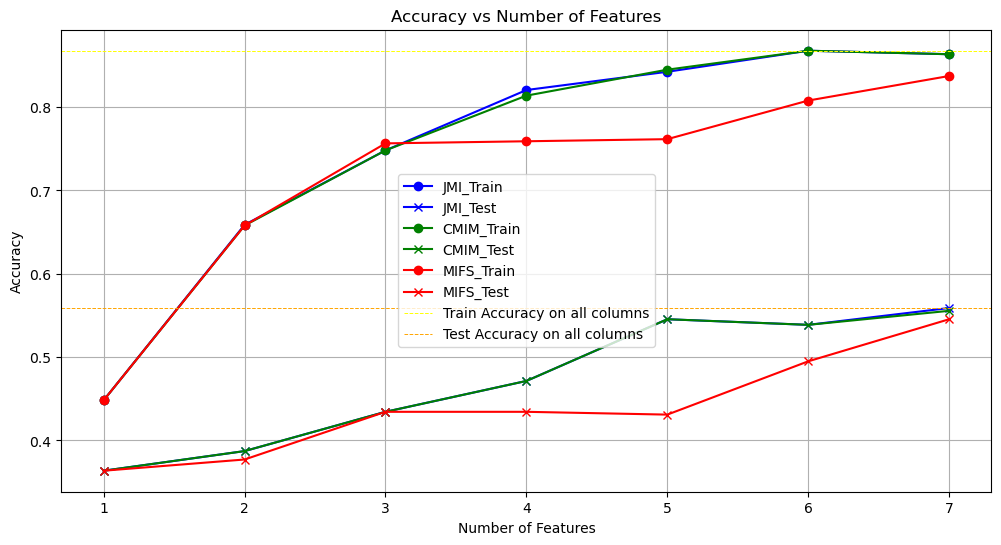

In [941]:
make_plot(df_yeast, scoreTrainYeast, scoreTestYeast)

<module 'matplotlib.pyplot' from 'C:\\Users\\szmadej\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

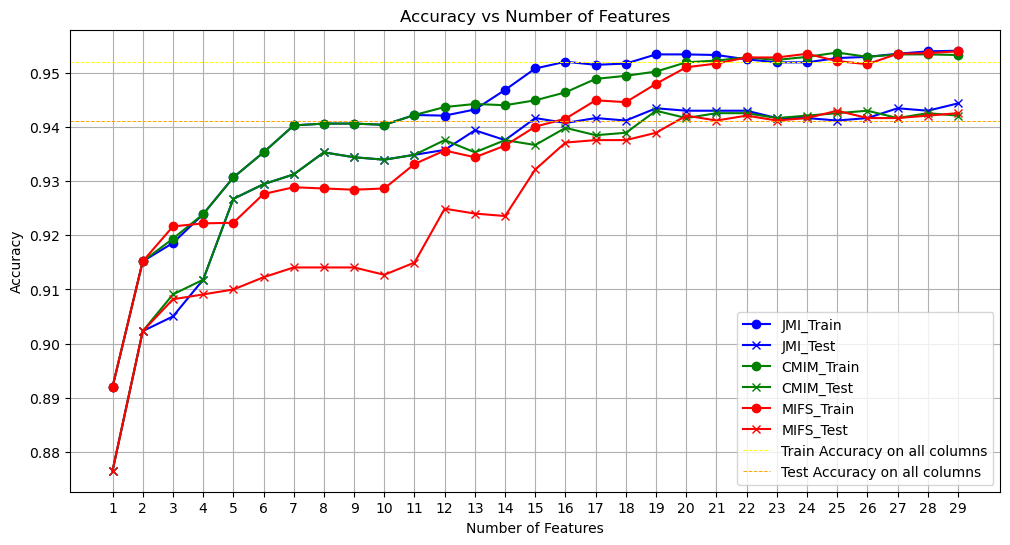

In [942]:
make_plot(df_phishing, scoreTrainphishing, scoreTestphishing)

<module 'matplotlib.pyplot' from 'C:\\Users\\szmadej\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

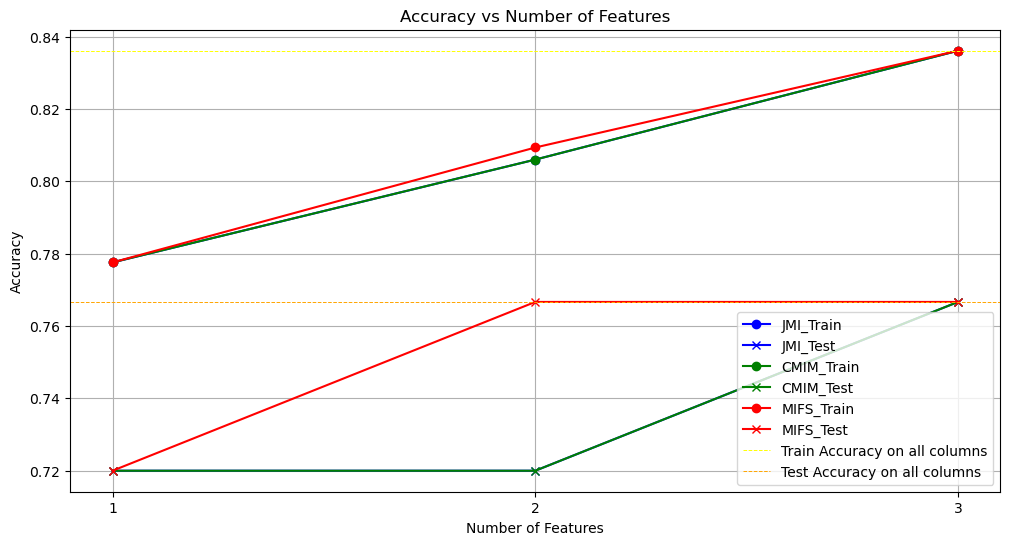

In [947]:
make_plot(df_blood, scoreTrainblood, scoreTestblood)

In [948]:
make_plot(df_rice, scoreTrainrice, scoreTestrice)

<module 'matplotlib.pyplot' from 'C:\\Users\\szmadej\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [969]:
make_plot(df_wine, scoreTrainwine, scoreTestwine)

<module 'matplotlib.pyplot' from 'C:\\Users\\szmadej\\AppData\\Local\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>